In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random

### Problem Statement: CP for A*u + noise

We are studying with a noisy matrix-vector multiplication:

$$
\hat{y} = A \cdot u + \text{noise}(A, u)
$$

Where:
- $ A $ is a matrix.
- $ u $ is a vector.
- The term $ \text{noise}(A, u) $ introduces variability into the outcome.

In the context of **split conformal prediction**, we are looking to create a prediction interval for $ \hat{y} $, given the model $ \hat{y} = A \cdot u $ and noise. The goal is to predict $ \hat{y} $ while accounting for the uncertainty introduced by the noise.

**Does split conformal prediction in this specific case keep coverage guarantee?**


1. **Fixed Predictor**:  
   The function $ f(A, u) $ that maps $ (A, u) $ to $ y $ is fixed in the sense that, given a pair $ (A, u) $, we know exactly what the model should output (if there were no noise). The variability comes from the noise term.

   $$
   \hat{y} = A \cdot u + \text{noise}(A, u)
   $$

2. **Calibration**:  
   Since the fundamental idea of split conformal prediction is to calibrate the non-conformity score based on the calibration set:
   - First, we compute the residuals (the difference between the predicted and true values) on the calibration set, i.e., the difference between $ A \cdot u $ and the noisy $ \hat{y} $.
   - Then, we calculate a threshold for the non-conformity score.

3. **Residuals**:  
   In the case of the noisy matrix-vector product $ \hat{y} = A \cdot u + \text{noise}(A, u) $, the residuals are the differences between the predicted values and the actual noisy observations.

   - **Predicted value**: $ y^* = A \cdot u $ (without the noise).
   - **Observed value**: $ \hat{y} = A \cdot u + \text{noise}(A, u) $.

   Thus, the residual for a given pair $ (A, u) $ is:

   $$
   \text{residual} = |\hat{y} - y^*| = |(A \cdot u + \text{noise}(A, u)) - A \cdot u| = |\text{noise}(A, u)|
   $$

   $$
   \text{residual} = |\text{noise}(A, u)|
   $$

   So the residuals represent the noise added to the matrix-vector product, which we want to capture when calibrating the model for conformal prediction.

### Types of Noise

In this problem, we are using two types of noise to explore how they affect the split conformal prediction procedure:

1. **i.i.d. Uniform Noise**:  
   This is a standard type of noise, where each noise term for every element in the matrix-vector product is drawn independently from an Uniform distribution, therefore we would keep exchangeability among residuals.

2. **Non-exchangeable Noise**:  
   In this case, the noise increases linearly with the index. For instance, the noise term for each element in the matrix-vector product grows as the index increases, i.e., the noise at index $ i $ might be proportional to $ i $. This is not exchangeable noise, as the noise magnitude depends on the position in the vector or matrix. (Not implemented in this version)



## Conformal Inference

## Split Conformal Prediction and Exchangeability

In **split conformal prediction**, we start with a dataset of **i.i.d.** observations:

$$
D = \{(X_1, Y_1), \dots, (X_n, Y_n), (X_{n+1}, Y_{n+1})\}
$$

where $$(X_i, Y_i) \sim P$$ are drawn from some unknown distribution \( $P$ \).

### Dataset Splitting
We split  $D$ into:

- A **proper training set** $ D_{\text{train}} $ used to fit the model.
- A **calibration set** $ D_{\text{calib}} $, typically consisting of $m$ points:

  $$
  D_{\text{calib}} = \{(X_{n-m+1}, Y_{n-m+1}), \dots, (X_n, Y_n)\}
  $$

- A **test point** $ D_{\text{test}} = \{(X_{n+1}, Y_{n+1})\} $, for which we construct a prediction set.

### Exchangeability Condition
The key requirement is that the **augmented dataset**:

$$
D_{\text{calib}} \cup D_{\text{test}} = \{(X_{n-m+1}, Y_{n-m+1}), \dots, (X_n, Y_n), (X_{n+1}, Y_{n+1})\}
$$

must be **exchangeable**. This means that for any permutation $\pi$, the joint distribution remains unchanged:

$$
(P_{\pi(n-m+1)}, \dots, P_{\pi(n+1)}) \overset{d}{=} (P_{n-m+1}, \dots, P_{n+1}).
$$

This ensures that the empirical distribution of residuals from $D_{\text{calib}} $ can be used to construct a valid prediction interval for $ Y_{n+1} $, maintaining marginal coverage guarantees.


### Parameters

In [ ]:
np.random.seed(0)

# Generating 1000 samples of A (4x4 matrices) and u (4x1 vectors)
num_samples = 100
dim = 4

# Adding noise to the y_true values using the add_noise function
# 'iid' or 'nonexchangeable_trend'
noise_type = 'nonexchangeable_trend' #'nonexchangeable_trend'#'iid'

### Data generation

In [ ]:
def add_noise(y_true, noise_type, position_in_dataset):
    if noise_type == 'iid':
        noise = np.random.uniform(0, 1, size=y_true.shape)  # iid uniform noise
    elif noise_type == 'nonexchangeable_trend':
        if position_in_dataset < 0.9:  # First 70%: non-exchangeable noise
            noise = np.random.uniform(0, 1, size=y_true.shape)
        else:  # Rest: iid noise
            indices = np.arange(len(y_true))
            noise = 10 * indices + np.random.normal(100, 50, size=y_true.shape)  # Strong trend + Gaussian noise

    return y_true + noise

In [ ]:
def generate_data(num_samples, dim, noise_type):
    A_samples = np.random.uniform(0, 1, (num_samples, dim, dim))  # matrices of size dimxdim
    u_samples = np.random.uniform(0, 1, (num_samples, dim))       # vectors of size dimx1

    # Generating y_true values for each sample (y_true = A * u)
    y_true_samples  = np.array([np.dot(A, u) for A, u in zip(A_samples, u_samples)])

    # Add noise based on position_in_dataset
    y_noisy_samples = np.array([add_noise(y_true, noise_type, i/num_samples) for i, y_true in enumerate(y_true_samples)])

    dataset = list(zip(y_noisy_samples, y_true_samples))
    #np.random.shuffle(dataset)

    return dataset

In [ ]:
#def generate_data(num_samples, dim, noise_type):
    # Generate random matrices A and vectors u
#    A_samples = np.random.uniform(0, 1, (num_samples, dim, dim))  # matrices of size dimxdim
#    u_samples = np.random.uniform(0, 1, (num_samples, dim))       # vectors  of size dimx1

    # Generating y_true values for each sample (y_true = A * u)
#    y_true_samples  = np.array([np.dot(A, u) for A, u in zip(A_samples, u_samples)])
#    y_noisy_samples = np.array([add_noise(y_true, noise_type) for y_true in y_true_samples])

#    dataset = list(zip(y_noisy_samples, y_true_samples))

#    return dataset

Generate set with 100 noisy output vectors and 100 non-noisy output vectors

In [ ]:
# Generate set with num_samples noisy output vectors and num_samples non-noisy output vectors
dataset = generate_data(num_samples, dim, noise_type)

# Extracting a  first sample
noisy, true = dataset[0]

# Check
print(f"Type of noise: {noise_type}")
print(f"Number of samples in dataset: {len(dataset)}")
print(f"Shape of noisy vectors: {noisy.shape}")
print(f"Shape of non-noisy vectors): {true.shape}")

Type of noise: nonexchangeable_trend
Number of samples in dataset: 100
Shape of noisy vectors: (4,)
Shape of non-noisy vectors): (4,)


### Splitting of data & Model training

In [ ]:
#np.random.shuffle(dataset)

train_data = dataset[:int(0.7*len(dataset))]                             # 70% for model training
calibration_data = dataset[int(0.7*len(dataset)):int(0.9*len(dataset))]  # 20% for conformal calibration
test_data = dataset[int(0.9*len(dataset)):]                              # 10% for conformal testing

X_train_noisy, Y_train_true = zip(*train_data)
X_calibration_noisy, Y_calibration_true = zip(*calibration_data)
X_test_noisy, Y_test_true = zip(*test_data)

# Tuples to arrays
X_train_noisy, Y_train_true = np.array(X_train_noisy), np.array(Y_train_true)
X_calibration_noisy, Y_calibration_true = np.array(X_calibration_noisy), np.array(Y_calibration_true)
X_test_noisy, Y_test_true = np.array(X_test_noisy), np.array(Y_test_true)

In [ ]:
# Train a model
model_coef = np.linalg.lstsq(X_train_noisy, Y_train_true, rcond=None)[0]  # Least squares solution

### Split Conformal Prediction

Calibration

In [ ]:
def split_conformal_prediction_with_test(X_calib, model_coef, Y_calib, alpha_value):

    y_pred_calib = np.dot(X_calib, model_coef)

    # Compute residuals
    residuals = np.abs(Y_calib - y_pred_calib)
    residuals_reduced = np.linalg.norm(residuals, axis=1)

    # Taking the norm among the n dimensions
    q_alpha = np.percentile(residuals_reduced, 100 * (1 - alpha_cp))

    return q_alpha

Testing, for computing empirical coverage and average prediction interval size

In [ ]:
def compute_coverage_and_interval_size(X_test, model_coef, Y_test, q_alpha):

    y_pred = np.dot(X_test, model_coef)

    lower_bound = y_pred - q_alpha
    upper_bound = y_pred + q_alpha

    residuals_test_set = np.abs(Y_test - y_pred)
    residuals_test_set = np.linalg.norm(residuals_test_set, axis=1)

    pred_test_set = np.abs(y_pred)
    pred_norm_test_set = np.linalg.norm(pred_test_set, axis=1)

    # Empirical coverage: percentage of true values within the prediction intervals
    coverage = np.mean((Y_test >= lower_bound) & (Y_test <= upper_bound)) * 100 # Element-wise comparation

    # Average prediction interval size
    avg_interval_size = np.mean(upper_bound - lower_bound)

    return coverage, avg_interval_size, lower_bound, upper_bound, y_pred, residuals_test_set, pred_norm_test_set

# Permutation Test

Permutation test asseses the only condition for CP, exchangeability of data(labels) to check for indepence among observations, ie that there are no underlying dependecies in the data (DeFinetti...)

### Exchangeability Condition
The key requirement is that the **augmented dataset**:

$$
D_{\text{calib}} \cup D_{\text{test}} = \{(X_{n-m+1}, Y_{n-m+1}), \dots, (X_n, Y_n), (X_{n+1}, Y_{n+1})\}
$$

must be **exchangeable**. This means that for any permutation $\pi$, the joint distribution remains unchanged:

$$
(P_{\pi(n-m+1)}, \dots, P_{\pi(n+1)}) \overset{d}{=} (P_{n-m+1}, \dots, P_{n+1}).
$$

This ensures that the empirical distribution of residuals from $D_{\text{calib}} $ can be used to construct a valid prediction interval for $ Y_{n+1} $, maintaining marginal coverage guarantees.

Exchangeability assumption has to hold between Calibration and Test sets, therefore we **concatenate** both to perform a permutation test

In [ ]:
X_permutation_noisy = np.concatenate((X_calibration_noisy, X_test_noisy), axis=0)
Y_permutation_true  = np.concatenate((Y_calibration_true, Y_test_true), axis=0)

In [ ]:
X_test_noisy.mean()

105.47797107137887

In [ ]:
X_test_noisy

array([[149.052665  ,  74.44496534,  83.4560221 ,  58.95999437],
       [231.73381871,  73.74512216,  55.7684814 ,  90.63406275],
       [ 62.32432613,  97.80324046, 161.52141031, 116.58169982],
       [ 54.44333968,  37.73697346, 121.3229579 , 132.7159194 ],
       [177.78855143, 115.2257673 , 116.14156089,  78.51264689],
       [ 86.64104085,  89.89757063, 103.28904127,  83.57012254],
       [128.17905922, 103.60437685, 110.97098649,  45.5042047 ],
       [126.33566133, 135.70315672,  79.51620556, 180.36172871],
       [ 32.87584702, 109.17301345, 107.80509246,  65.80134975],
       [110.810937  , 196.80046006, 124.18448625, 108.18097648]])

In [ ]:
N = len(X_permutation_noisy)
max_permutations = math.factorial(N)

print(N, max_permutations)

30 265252859812191058636308480000000


array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
       [<Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>]],
      dtype=object)

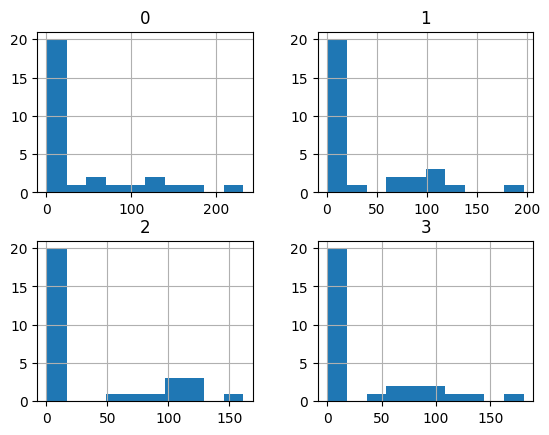

In [ ]:
pd.DataFrame(X_permutation_noisy).hist()

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
       [<Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>]],
      dtype=object)

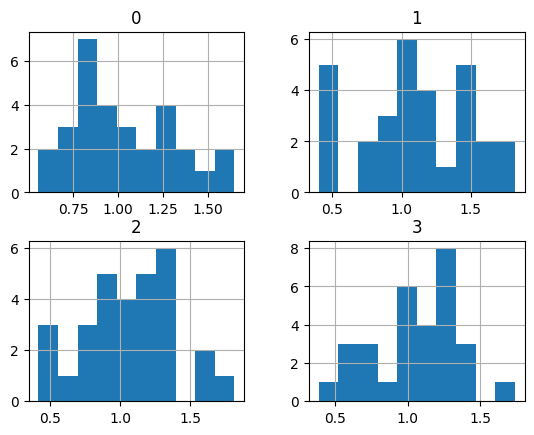

In [ ]:
pd.DataFrame(Y_pred).hist()

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
       [<Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>]],
      dtype=object)

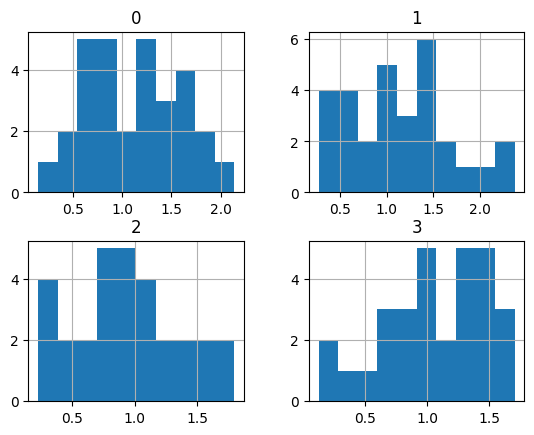

In [ ]:
pd.DataFrame(Y_permutation_true).hist()

In [ ]:
# Computing the residual as the diff between vectors and taking the norm as unique parameter/statistic
def mean_euclidean_distance(A, B):
    return np.mean(np.linalg.norm(A - B, axis=1))

# Observed distance/residual in initial data
Y_pred = np.dot(X_permutation_noisy, model_coef)
D_obs = mean_euclidean_distance(Y_pred, Y_permutation_true)

# Permutation test
num_permutations = 10000
D_perm = []

for _ in range(num_permutations):
    permuted = Y_pred.copy()
    np.random.shuffle(permuted)
    D_perm.append(mean_euclidean_distance(Y_permutation_true, permuted))

D_perm = np.array(D_perm)

# p-value
p_value = np.mean(D_obs <= D_perm) # is the order important? check this...

# Result
print(f"Observed distance/residual: {D_obs:.4f}")
print(f"Mean permuted distance/residual: {np.mean(D_perm):.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    permutation_test = 'Permutation Test Not Passed'
    print("We reject the null hypothesis of Exchangeability.", permutation_test)

else:
    permutation_test = 'Permutation Test Passed'
    print("No sufficient evidence to reject Exchangeability.", permutation_test)

array([50.058998  , 50.00646224, 50.12154833, ..., 50.13313288,
       50.05735749, 50.1368318 ])

## Why do we need exchangeability?

We can compute the probability of how the residual $ R_{n+1} $ would be ranked among the other residuals (i.e. conformity scores):

$$
\pi = \frac{1}{n+1} \sum_{i=1}^{n+1} \mathbb{I}  \{ R_{n+1} \leq  R_i\} = \frac{1}{n+1} + \frac{1}{n+1} \sum_{i=1}^{n}\mathbb{I}  \{ R_{n+1} \leq  R_i\}
$$

where $ \mathbb{I}\{\cdot\}$, the indicator function, evaluates whether the score $ R_{n+1} $ is less than or equal to the score $ R_i $.

Due to the exchangeability of the data points and the scores (given by the symmetry of the predictor), the probability $ \pi $ is uniformly distributed over the set:

$$
\left\{ \frac{1}{n+1}, \frac{2}{n+1}, \dots, \frac{n+1}{n+1} \right\}
$$

which implies that:

$$
\mathbb{P}(R_{n+1} \leq R_k) = \frac{k}{n+1}, \quad \text{for any } k \in \{1, 2, \dots, n+1\}
$$

where \( k \) refers to the particular order statistic of \( R_k \).

Finally, we can conclude that the probability that the score $ R_{n+1} $ lies below the quantile $ \lceil (n+1)(1-\alpha) \rceil $ is at least $ 1 - \alpha $, that is:

$$
\mathbb{P}(R_{n+1} \leq R_{\lceil (n+1)(1-\alpha) \rceil}) = \frac{\lceil (n+1)(1-\alpha) \rceil}{n+1} \geq 1 - \alpha
$$

---

Thus, the probability that the ground truth $ Y_{n+1} $ would be realized in the prediction set $ C(X_{n+1}) $ is:

$$
\mathbb{P}(R_{n+1} \leq \hat{q}) = \mathbb{P}(Y_{n+1} \in C(X_{n+1})) \geq 1 - \alpha
$$

This directly expresses that the event of $ Y_{n+1} $ belonging to $ C(X_{n+1}) $ corresponds to the non-conformity score $ S_{n+1} $ being less than or equal to the calibration quantile $ \hat{q} $, and ensures that the ground truth is contained in the prediction set with at least $ 1 - \alpha $ probability, satisfying the marginal coverage guarantee.


# Conformal Prediction Results
* $\text{Coverage (empirical):} \,  \frac{1}{n} \sum_{i \in \text{Test}} \mathbb{I}\left(y^*_i  \in \left[\hat{y}_i + q_{1-\alpha}, \hat{y}_i - q_{1-\alpha}\right]\right) \cdot 100\%$

* $\text{Average Size:} \, \frac{1}{n}\sum_{i \in \text{Test}} \left( \text{Upper Bound}_i - \text{Lower Bound}_i \right)$

* $\text{Expected Relative Residual:} \, \mathbb{E}\left[\frac{\|y_i - \hat{y}_i\|}{\|\hat{y}_i\|}\right] = \frac{1}{n}\sum_{i \in \text{Test}}\frac{\text{residuals}_i}{\text{pred_norm}_i}$

* $\text{Expected Relative Interval Size:} \, \mathbb{E}\left[\frac{\sqrt{n} \cdot q_{1-\alpha}}{\|\hat{y}_i\|}\right] = \frac{1}{n}\sum_{i \in \text{Test}}\frac{\sqrt{n} \cdot q_{1-\alpha}}{\text{pred_norm}_i}$

In [ ]:
# Desired alpha/error level for Conformal Prediction
alpha_cp   = 0.1

## noise_type = 'iid'

In [ ]:
if noise_type == 'iid':

  q_alpha_iid = split_conformal_prediction_with_test(X_calib = X_calibration_noisy, model_coef = model_coef, Y_calib = Y_calibration_true, alpha_value=alpha_cp)
  coverage_iid, avg_size_iid, lower_bound_iid, upper_bound_iid, y_pred_iid, residuals_test_set_iid, pred_norm_test_set_iid = compute_coverage_and_interval_size(X_test_noisy, model_coef, Y_test_true, q_alpha_iid)

  print(f' {permutation_test} \n Coverage marginal: {coverage_iid}\n Coverage (empirical) guarantee satisfied?: {coverage_iid >= (1-alpha_cp)*100}\n Avg Interval Size: {(np.abs(avg_size_iid))} \n Expected Relative Residual: {(np.mean(residuals_test_set_iid/pred_norm_test_set_iid))} \n Expected Relative Interval Size: {(np.mean((np.sqrt(2)*q_alpha_iid)/pred_norm_test_set_iid))}')

## noise_type = 'non-exchangeable'

In [ ]:
if noise_type == 'nonexchangeable_trend':

  q_alpha_nonexchangeable = split_conformal_prediction_with_test(X_calib = X_calibration_noisy, model_coef = model_coef, Y_calib = Y_calibration_true, alpha_value=alpha_cp)
  coverage_nonexchangeable, avg_size_nonexchangeable, lower_bound_nonexchangeable, upper_bound_nonexchangeable, y_pred_nonexchangeable, residuals_test_set_nonexchangeable, pred_norm_test_set_nonexchangeable = compute_coverage_and_interval_size(X_test_noisy, model_coef, Y_test_true, q_alpha_nonexchangeable)

  print(f' {permutation_test} \n Coverage marginal: {coverage_nonexchangeable}\n Coverage (empirical) guarantee satisfied?: {coverage_nonexchangeable >= (1-alpha_cp)*100}\n Avg Interval Size: {(np.abs(avg_size_nonexchangeable))} \n Expected Relative Residual: {(np.mean(residuals_test_set_nonexchangeable/pred_norm_test_set_nonexchangeable))} \n Expected Relative Interval Size: {(np.mean((np.sqrt(2)*q_alpha_nonexchangeable)/pred_norm_test_set_nonexchangeable))}')

 Permutation Test Passed 
 Coverage marginal: 0.0
 Coverage (empirical) guarantee satisfied?: False
 Avg Interval Size: 1.5112275059911489 
 Expected Relative Residual: 0.9860545289430529 
 Expected Relative Interval Size: 0.007402496952031557
